In [1]:
import sys
print(sys.executable)

c:\Python312\python.exe


In [24]:
import os
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from pickle import dump, load

from imblearn.over_sampling import SMOTE, ADASYN


In [ ]:
# # Define function to load images
# def load_images(images_folder, save_file_to=None):
#     X_original = []
#     X = []
#     y = []
    
#     for subdir, dirs, files in os.walk(images_folder):
#         for file in files:
#             if file.endswith(('jpg', 'jpeg', 'png')):
#                 img_path = os.path.join(subdir, file)
#                 label = os.path.basename(subdir)
                
#                 image = Image.open(img_path).convert('L')
#                 image = image.resize((48, 48))
#                 X_original.append(np.array(image).flatten())
#                 X.append(np.array(image).flatten())
#                 y.append(label)
    
#     if save_file_to:
#         with open(save_file_to, "wb") as f:
#             dump((X_original, X, y), f, protocol=5)
    
#     return np.array(X_original), np.array(X), np.array(y)

# # Define paths
# images_folder = 'D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images'
# dataset_file = "dataset_dump.pkl"

# X_original, X, y = load_images(images_folder, save_file_to=dataset_file)

Attempting to load existing dataset...
Dataset loaded successfully!


In [16]:
with open("dataset_dump.pkl", "rb") as f:
    X_original,X,y = load(f)

In [17]:
# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

X
y

array(['angry', 'angry', 'angry', ..., 'surprise', 'surprise', 'surprise'],
      dtype='<U8')

In [25]:


def preprocessing_data(X, y, save_file_to=None):
    # Normalize pixel values
    X = X / 255.0  

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Dimensionality reduction with PCA (whitening to decorrelate)
    pca = PCA(n_components=100, whiten=True, random_state=42)
    X_reduced = pca.fit_transform(X)

    # Standardize the data
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_reduced)
    print(X_scaled.shape)

    if save_file_to:
        with open(save_file_to, "wb") as f:
            dump((X_scaled, y_encoded, label_encoder, scaler), f, protocol=5)

    return X_scaled, y_encoded, label_encoder, scaler

# Preprocess data
preprocessed_file = "improved_preprocessed_data.pkl"
X_scaled, y_encoded, label_encoder ,scaler = preprocessing_data(X, y, save_file_to=preprocessed_file)


(35887, 100)


In [26]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (28709, 100), Test set: (7178, 100)


In [27]:
X_train[0]

array([-1.29283419,  0.7217981 ,  0.31857445, -0.15048883,  0.18858129,
        0.50408526,  0.33447582,  0.58483318,  0.21650023,  0.04047951,
        0.62428034,  0.53846987,  0.6248745 ,  0.28506509,  0.09582111,
       -0.35322818,  0.92444972,  0.12695514,  0.26749355,  0.29408132,
       -0.11827853, -1.4030029 ,  0.30975036, -0.562229  ,  0.33651663,
       -0.22045851,  0.81731418,  0.08748369,  0.08808597,  0.05773304,
       -0.71083802,  0.14859976, -0.36334362,  0.785303  , -0.64586754,
        1.19828551,  0.45910317, -0.12173407, -0.02355552,  0.00707317,
       -0.44842006, -0.1486052 ,  0.2584939 ,  0.29625538,  0.24720982,
        0.73657186,  0.87971031,  0.92785074,  0.17032925,  1.07955673,
       -0.15922407, -0.45740232, -0.24685577, -0.35044889, -0.84825405,
        0.12494495, -0.72438052, -0.48170213, -0.03675207, -0.34592051,
        0.81836093,  0.49702777,  0.20779309, -0.55502795, -1.01761812,
       -0.48039815, -0.0832622 , -0.08322665, -0.1737154 ,  0.91

In [28]:
def handle_class_imbalance(X_train, y_train, strategy='smote_adasyn'):
    """
    Handles class imbalance by checking distribution and applying either SMOTE, ADASYN, or a combination.
    """
    # Check class distribution
    unique, counts = np.unique(y_train, return_counts=True)
    class_dist = dict(zip(unique, counts))
    print("Class distribution before balancing:", class_dist)
    
    # Only apply resampling if imbalance exceeds the threshold
    if max(counts) / min(counts) > 1.5:  
        print("Detected class imbalance, applying resampling...")

        if strategy == 'smote':
            smote = SMOTE(random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        elif strategy == 'adasyn':
            adasyn = ADASYN(random_state=42)
            X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

        elif strategy == 'smote_adasyn':
            smote_adasyn = SMOTE(sampling_strategy='minority', random_state=42)
            X_resampled, y_resampled = smote_adasyn.fit_resample(X_train, y_train)

        else:
            raise ValueError("Invalid strategy. Choose from 'smote', 'adasyn', 'smote_adasyn'.")

        # Show new distribution
        unique_after, counts_after = np.unique(y_resampled, return_counts=True)
        print("Class distribution after balancing:", dict(zip(unique_after, counts_after)))
        return X_resampled, y_resampled

    print("No significant class imbalance detected.")
    return X_train, y_train

# Example usage
X_train_balanced, y_train_balanced = handle_class_imbalance(X_train, y_train, strategy='smote_adasyn')


Class distribution before balancing: {np.int64(0): np.int64(3943), np.int64(1): np.int64(442), np.int64(2): np.int64(4056), np.int64(3): np.int64(7223), np.int64(4): np.int64(4986), np.int64(5): np.int64(4863), np.int64(6): np.int64(3196)}
Detected class imbalance, applying resampling...
Class distribution after balancing: {np.int64(0): np.int64(3943), np.int64(1): np.int64(7223), np.int64(2): np.int64(4056), np.int64(3): np.int64(7223), np.int64(4): np.int64(4986), np.int64(5): np.int64(4863), np.int64(6): np.int64(3196)}


In [29]:

# Feature selection
def select_features(X_train, X_test, y_train, k=None):
    if k is None:
        k = min(200, X_train.shape[1])  # Default: select top 200 features or less
    else:
        k = min(k, X_train.shape[1])  # Ensure k doesn't exceed available features
        
    print(f"Selecting top {k} features...")
    
    # Use f_classif which works for any input values (unlike chi2 which requires non-negative)
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    print(f"Features reduced from {X_train.shape[1]} to {X_train_selected.shape[1]}")
    return X_train_selected, X_test_selected, selector

X_train_selected, X_test_selected, selector = select_features(X_train_balanced, X_test, y_train_balanced)


Selecting top 100 features...
Features reduced from 100 to 100


In [ ]:

def optimize_knn_with_output(X_train, y_train, X_test, y_test, label_encoder, cv=1):
    param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'p': [1, 2, 3, 4],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 50]
}


    print("\n🔍 Tuning KNN Hyperparameters with Cross-Validation...\n")
    print("-----------------------------------------")
    print(f"📌 Cross-validation: {cv}-fold")
    print(f"🛠️ Hyperparameter Grid: {len(ParameterGrid(param_grid))} combinations")
    print("-----------------------------------------\n")

    best_combination = None
    best_accuracy = 0
    all_combinations = list(ParameterGrid(param_grid))

    for idx, combination in enumerate(all_combinations, start=1):
        print(f"Combination {idx}/{len(all_combinations)}: {combination}")

        knn_model = KNeighborsClassifier(**combination)
        knn_model.fit(X_train, y_train)

        # Make predictions
        y_pred = knn_model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        print(f"▶ Accuracy: {accuracy:.2f}")
        print("▶ Classification Report:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
        print("-" * 60)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_combination = combination

    # Print the best combination
    print("\n✅ Best Combination:", best_combination)
    print(f"🏅 Best Accuracy: {best_accuracy:.4f}")
    print("Total combinations tested:", len(all_combinations))

    # Train the final model with the best parameters
    best_model = KNeighborsClassifier(**best_combination)
    best_model.fit(X_train, y_train)

    return best_model, best_combination


# Example usage:
best_model, best_params = optimize_knn_with_output(X_train, y_train, X_test, y_test, label_encoder, cv=1)



🔍 Tuning KNN Hyperparameters with Cross-Validation...

-----------------------------------------
📌 Cross-validation: 1-fold
🛠️ Hyperparameter Grid: 3584 combinations
-----------------------------------------

Combination 1/3584: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
▶ Accuracy: 0.35
▶ Classification Report:
              precision    recall  f1-score   support

       angry       0.28      0.37      0.32      1010
     disgust       0.15      0.38      0.21       105
        fear       0.30      0.38      0.33      1065
       happy       0.46      0.39      0.42      1766
     neutral       0.28      0.37      0.32      1212
         sad       0.39      0.20      0.26      1214
    surprise       0.66      0.38      0.48       806

    accuracy                           0.35      7178
   macro avg       0.36      0.35      0.33      7178
weighted avg       0.38      0.35      0.35      7178

---------------------

In [ ]:

# Evaluate the model
def evaluate_model(model, X_test, y_test, label_encoder):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"\nModel Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    return y_pred, accuracy

y_pred, accuracy = evaluate_model(best_model, X_test_selected, y_test, label_encoder)



Model Evaluation:
Accuracy: 0.3885

Classification Report:
              precision    recall  f1-score   support

       angry       0.40      0.27      0.32      1010
     disgust       0.30      0.47      0.37       105
        fear       0.40      0.37      0.38      1065
       happy       0.49      0.41      0.44      1766
     neutral       0.26      0.44      0.33      1212
         sad       0.33      0.30      0.32      1214
    surprise       0.61      0.57      0.59       806

    accuracy                           0.39      7178
   macro avg       0.40      0.40      0.39      7178
weighted avg       0.41      0.39      0.39      7178



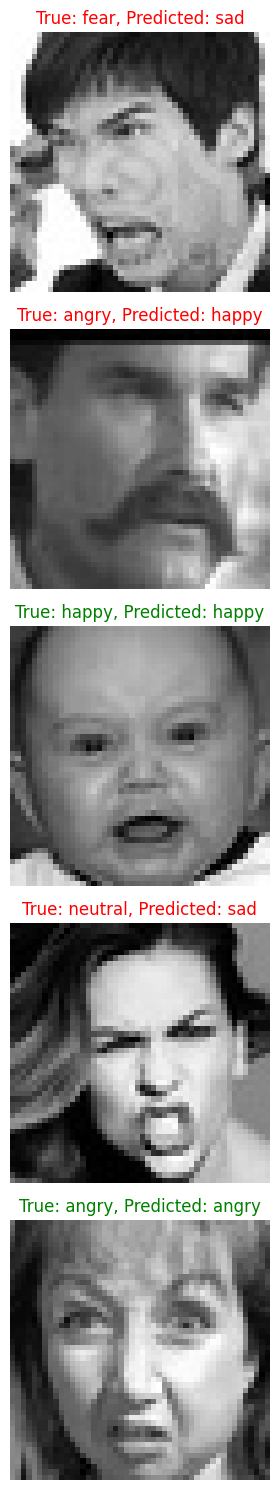

In [ ]:

# Visualize predictions
def visualize_predictions(model, X_test, y_test, label_encoder, X_original, indices=None, num_samples=5):
    y_pred = model.predict(X_test)
    
    # If specific indices not provided, sample random ones
    if indices is None:
        indices = np.random.choice(len(y_test), min(num_samples, len(y_test)), replace=False)
    
    plt.figure(figsize=(15, 3*len(indices)))
    
    for i, idx in enumerate(indices):
        plt.subplot(len(indices), 1, i+1)
        original_image = X_original[idx].reshape(48, 48)
        plt.imshow(original_image, cmap='gray')
        
        correct = y_test[idx] == y_pred[idx]
        color = 'green' if correct else 'red'
        
        plt.title(f"True: {label_encoder.inverse_transform([y_test[idx]])[0]}, "
                  f"Predicted: {label_encoder.inverse_transform([y_pred[idx]])[0]}",
                  color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(best_model, X_test_selected, y_test, label_encoder, X_original)


In [ ]:

# Save the final model
model_file = "improved_knn_model.pkl"
with open(model_file, "wb") as f:
    dump((best_model, pca, scaler, selector, label_encoder, best_params), f, protocol=5)
print(f"Model saved to {model_file}")

# To load and use the model later:
# with open(model_file, "rb") as f:
#     best_model, pca, scaler, selector, label_encoder, best_params = load(f)
#
# # For new data:
# def predict_new_image(image_path, model, pca, scaler, selector, label_encoder):
#     # Load and preprocess image
#     image = Image.open(image_path).convert('L')
#     image = image.resize((48, 48))
#     flat_image = np.array(image).flatten() / 255.0
#     
#     # Apply transformations
#     transformed = pca.transform([flat_image])
#     transformed = scaler.transform(transformed)
#     transformed = selector.transform(transformed)
#     
#     # Predict
#     prediction = model.predict(transformed)
#     label = label_encoder.inverse_transform(prediction)[0]
#     
#     return label

NameError: name 'pca' is not defined